<a href="https://colab.research.google.com/github/MarcLefevreFr/OpenClassrooms/blob/master/P7/P7_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Approche à partir de :<br>https://www.kaggle.com/anasofiauzsoy/tutorial-notebook<br>https://www.kaggle.com/c/contradictory-my-dear-watson

### **Liaison Google Drive**


In [1]:
# instal google drive
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


### **Importation en local des données**

In [2]:
# install librairie huggin face transformers
pip install transformers

     |████████████████████████████████| 2.5MB 5.3MB/s 
     |████████████████████████████████| 3.3MB 38.2MB/s 
     |████████████████████████████████| 901kB 59.6MB/s 


In [26]:
# début données
import shutil
import os
import pickle
import numpy as np
from time import time

os.environ["WANDB_API_KEY"] = "0" ## to silence warning

from tensorflow.keras.callbacks import ModelCheckpoint
from transformers import BertTokenizer, TFBertModel
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import f1_score

In [4]:
cwd = os.getcwd()

path_data = cwd + "/drive/MyDrive/P7/Data/"

# pour keras implé, les données qui nous intéressent sont les données textes préparés, en token cad :
# feat_train_clean_tk + feat_test_clean_tk

for file in os.listdir(path_data) :
    shutil.copy(os.path.join(path_data, file), cwd)

os.listdir(cwd)

['.config',
 'y_test.pickle',
 'drive',
 'y_train.pickle',
 'X_train_ft_pca.pickle',
 'feat_test_clean.pickle',
 'labels.pickle',
 'X_test_ft_pca.pickle',
 'feat_train_clean.pickle',
 'sample_data']

### **Récup Données**

In [5]:
X_train = pickle.load(open("feat_train_clean.pickle", "rb"))
X_test = pickle.load(open("feat_test_clean.pickle", "rb"))

y_train = pickle.load(open("y_train.pickle", "rb"))
y_test = pickle.load(open("y_test.pickle", "rb"))

y_train = y_train.toarray()
y_test = y_test.toarray()

### **Elements stats sur les données**

In [ ]:
print(f"Nombre de questions d'entrainement : {len(X_train)}")
print(f"Nombre de questions de test : {len(X_test)}")

Nombre de questions d'entrainement : 20000
Nombre de questions de test : 5555


In [ ]:
longueurs_train = []
longueurs_test = []

for quest in X_train :
    longueurs_train.append(len(quest))
l_train_max = max(longueurs_train)

for quest in X_test :
    longueurs_test.append(len(quest))
l_test_max = max(longueurs_test)


print(f"Nombre de mots max dans les données d'entrainement : {l_train_max}")
print(f"Nombre de mots moyen dans les données d'entrainement : {np.mean(longueurs_train)}")
print(f"Déviation standart du nombre de mots dans les données d'entrainement : {np.std(longueurs_train)}")

print()
print(f"Nombre de mots max dans les données de test : {l_test_max}")
print(f"Nombre de mots moyen dans les données de test : {np.mean(longueurs_test)}")
print(f"Déviation standart du nombre de mots dans les données de test : {np.std(longueurs_test)}")

print()
print(f"Nombre de mots max totale : {max([l_train_max, l_test_max])}")

Nombre de mots max dans les données d'entrainement : 1127
Nombre de mots moyen dans les données d'entrainement : 43.4608
Déviation standart du nombre de mots dans les données d'entrainement : 34.77525073036857

Nombre de mots max dans les données de test : 826
Nombre de mots moyen dans les données de test : 43.437443744374434
Déviation standart du nombre de mots dans les données de test : 35.55000031446479

Nombre de mots max totale : 1127


**En longueur de nombre de mots pour nos questions, on prendra la valeur de 90**

### **Vocabulaire**

In [ ]:
def get_vocab_length(data):

    vocab = []

    for ligne in data :

        for word in set(ligne) :

            vocab.append(word)
    
    return len(set(vocab)), set(vocab)

nb_train, voc_train = get_vocab_length(X_train)
nb_test, voc_test = get_vocab_length(X_test)

unique_test = [x for x in voc_test if x not in voc_train]

common = list(set(voc_test).intersection(voc_train))
print(len(common))

print(f"Vocabulaire des données train : {nb_train}")
print(f"Vocabulaire des données test : {nb_test}")
print(f"Nombres de mots des données test inconnus des données train : {len(unique_test)}")

11766
Vocabulaire des données train : 62211
Vocabulaire des données test : 24367
Nombres de mots des données test inconnus des données train : 12601


### **Implémentation 2**

**Liste de modèles Bert**<br>https://huggingface.co/transformers/pretrained_models.html<br>On va utiliser "bert_base_uncased"

In [12]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [11]:
# IDS = position dans la liste demots différents classés par freq décroissante...


# renvoie les token_ids et ajoutant les ['CLS] de début de phrase et les "[SEP] de fin de phrase"
def bert_encode_ids(quest):

    tokens = list(tokenizer.tokenize(quest))
    tokens.append('[SEP]')
    tokens.insert(0, "[CLS]")
    return tokenizer.convert_tokens_to_ids(tokens)

In [ ]:
print(bert_encode_ids(X_train[0]))

[101, 24234, 5896, 2517, 2503, 22091, 2015, 23375, 3853, 4339, 24234, 5896, 2503, 23375, 3853, 3191, 22091, 2015, 9986, 2015, 15389, 3642, 2517, 18750, 13045, 22578, 9262, 3855, 5491, 2825, 2224, 24234, 5509, 3350, 4637, 2742, 102]


Ici **subword based toenisation** --> cf vidéo hugginface

**Essai 1**<br>juste les ids...

In [ ]:
def bert_encode_1(data):

    questions_enc = tf.ragged.constant([bert_encode_ids(q) for q in np.array(data)])

    return questions_enc

In [ ]:
data_enc = bert_encode_1(X_train)

In [ ]:
data_enc[100]

<tf.Tensor: shape=(100,), dtype=int32, numpy=
array([  101, 14817,  5746,  4942, 27430,  2678, 21461,  8737, 13910,
        3674,  5746,  3162,  4942, 27430, 14817,  2309,  1012, 12395,
        2615,  5371,  1049,  2047, 21461,  8737, 13910, 10954,  2310,
        2699,  5746, 21461,  8737, 13910,  2678,  1012, 12395,  2615,
        1058,  2078,  9353, 10244,  2278,  6100,  5746,  1012,  9779,
        2278, 14817,  5746,  2215,  2425, 21461,  8737, 13910, 14817,
        2309,  5746,  6764,  4942,  3775,  9286,  6764,  7688,  2434,
        6764, 14305, 23961,  2113,  5331,  5746,  6764,  2672,  1012,
       13109,  6305,  1012,  9779,  2278,  1049,  2469,  7300,  1040,
        2179,  3784,  8552,  2342, 17959,  2113,  2573, 17708,  3094,
        2925,  2126,  3740,  2448,  3642,  3645,  4642,  2094,  4283,
         102], dtype=int32)>

On a un array de dim fluctuante

In [ ]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*data_enc.shape[0]
input_word_ids = tf.concat([cls, data_enc], axis=-1)

In [ ]:
input_word_ids[0]

<tf.Tensor: shape=(38,), dtype=int32, numpy=
array([  101,   101, 24234,  5896,  2517,  2503, 22091,  2015, 23375,
        3853,  4339, 24234,  5896,  2503, 23375,  3853,  3191, 22091,
        2015,  9986,  2015, 15389,  3642,  2517, 18750, 13045, 22578,
        9262,  3855,  5491,  2825,  2224, 24234,  5509,  3350,  4637,
        2742,   102], dtype=int32)>

In [ ]:
input_mask = tf.ones_like(data_enc).to_tensor()

In [ ]:
input_mask.shape

TensorShape([20000, 6421])

In [ ]:
input_mask[100]

<tf.Tensor: shape=(6421,), dtype=int32, numpy=array([1, 1, 1, ..., 0, 0, 0], dtype=int32)>

Number of replicas: 1


**Test sur la longueur des vecteurs**

In [ ]:
# test :
input_wordids = tf.ragged.constant([bert_encode_ids(q) for q in np.array(X_train)])

In [ ]:
# forme objet et formes d'éléments...
# les éléments ont des longueurs différentes...
input_wordids.shape, input_wordids[0].shape, input_wordids[154].shape

(TensorShape([20000, None]), TensorShape([37]), TensorShape([54]))

In [ ]:
# mise son forme de tenseur ---> ca va créer le PADDING -> mise à même longueur de tous les vecteurs avec des 0
input_wordids = input_wordids.to_tensor(shape = [input_wordids.shape[0], 150])

In [ ]:
# vérification
input_wordids.shape, input_wordids[0].shape, input_wordids[154].shape

(TensorShape([20000, 150]), TensorShape([150]), TensorShape([150]))

In [ ]:
print(input_wordids[0])

tf.Tensor(
[  101 24234  5896  2517  2503 22091  2015 23375  3853  4339 24234  5896
  2503 23375  3853  3191 22091  2015  9986  2015 15389  3642  2517 18750
 13045 22578  9262  3855  5491  2825  2224 24234  5509  3350  4637  2742
   102     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0], shape=(150,), dtype=int32)


In [ ]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [31]:
def bert_encode_ids(quest):

    tokens = list(tokenizer.tokenize(quest))
    tokens.append('[SEP]')
    tokens.insert(0, "[CLS]")
    return tokenizer.convert_tokens_to_ids(tokens)


def bert_encode(data, question_length):

    data = np.array(data)

    shape_data = [data.shape[0], question_length]

    input_word_ids = tf.ragged.constant([bert_encode_ids(q) for q in data])

    input_mask = tf.ones_like(input_word_ids).to_tensor(shape = shape_data)

    input_type_ids = tf.zeros_like(input_word_ids).to_tensor(shape = shape_data)

    #input_mask = tf.ones_like(input_word_ids).to_tensor()

    #input_type_ids = tf.zeros_like(input_word_ids).to_tensor()


    inputs = {
    'input_word_ids': input_word_ids.to_tensor(shape = shape_data),
#    'input_word_ids': input_word_ids.to_tensor(),

    'input_mask': input_mask,
    'input_type_ids': input_type_ids}

    return inputs

In [32]:
train_inputs = bert_encode(X_train, 90)
test_inputs = bert_encode(X_test, 90)
#inputs = bert_encode(X_train)

In [38]:
for k in train_inputs.keys():

    print(train_inputs[k].shape)

for k in test_inputs.keys():

    print(test_inputs[k].shape)

(20000, 90)
(20000, 90)
(20000, 90)
(5555, 90)
(5555, 90)
(5555, 90)


In [36]:

def build_model():

    max_len = 90

    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")

    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]

    output = tf.keras.layers.Dense(25, activation='sigmoid')(embedding[:,0,:])

    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)

    model.compile(tf.keras.optimizers.Adam(learning_rate = 1e-5), loss='binary_crossentropy', metrics=['accuracy'])

    return model

def f1sw(preds, target):

    f1_sc = f1_score(target, preds, average = "weighted")

    return f1_sc

**Config env TPU**

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # KM: detect and init the TPU: TPUClusterResolver() locates the TPUs on the network
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu) # KM: "strategy" contains the necessary distributed training code that will work on the TPUs
except ValueError: # KM: in case Accelerator is not set to TPU in the Notebook Settings
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync) # KM: returns the number of cores

Création du modèle dans cette env...

In [ ]:
with strategy.scope():
    model = build_model()
    model.summary()

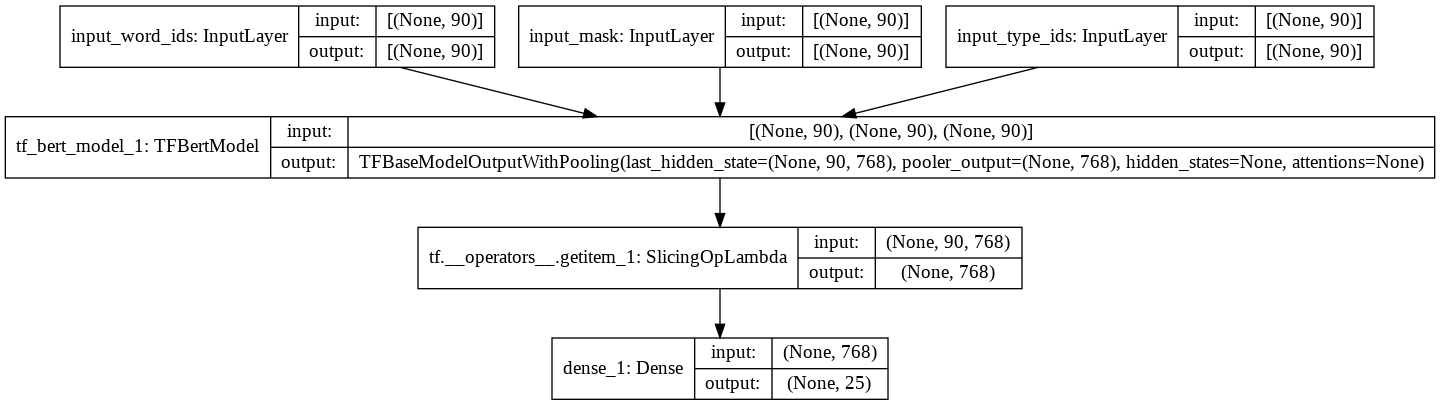

In [23]:
tf.keras.utils.plot_model(model, "my_model.png", show_shapes=True)

In [ ]:
start = time()

model.fit(inputs, y_train, epochs = 10, verbose = 1, batch_size = 32, validation_split = 0.2)

print(f"L'entrainement a pris : {time()-start:.0f} sec.")

In [57]:
def modelize(model, epochs, data, mod_name):
    """
    Fonction de modélisation.
    """
    # checkpoint = ModelCheckpoint(filepath = "/drive/MyDrive/P7/Data/" + mod_name, 
    #                              monitor = "val_accuracy",
    #                              verbose = 1,
    #                              save_best_only = True)
    
    start = time()

    history = model.fit(data[0], 
                        data[1],
                        epochs = epochs,
                        batch_size = 32,
                        validation_split = 0.2)#,
                        #callbacks = [checkpoint])
    
    #val_acc = history.history['val_accuracy'][-1]
    
    preds = model.predict(data[2])
    
    pred = preds.round()
    
    f1_sc = f1_score(data[3],
                     pred,
                     average = "weighted")
    
    fig = plt.figure(figsize = (10,4))

    train_acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    
    plt.plot(range(1, epochs+1), train_acc, 'b', label='Train acc', color = "red")
    plt.plot(range(1, epochs+1), val_acc, 'b', label='Validation acc', color = "blue")
    plt.title('Train & validation accuracies - ' + mod_name)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    print()
    print(f"Temps d'entrainements pour {epochs} epochs : {time()-start:.0f} secondes.")
    print(f"Meilleure train_acc = {np.max(train_acc):.3f}, meilleure val_acc = {np.max(val_acc):.3f}")
    print()
    print(f"F1_score obtenu : {f1_sc:.2f}")

    plt.show()

In [58]:
with strategy.scope():
    model1 = build_model()
    model1.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 90)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 90)]         0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 90)]         0                                            
__________________________________________________________________________________________________
tf_bert_model_7 (TFBertModel)   TFBaseModelOutputWit 109482240   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [59]:
DATA = [train_inputs, y_train, test_inputs, y_test]

Epoch 1/10


500/500 [==============================] - ETA: 0s - loss: 0.1555 - accuracy: 0.4254WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


500/500 [==============================] - 99s 78ms/step - loss: 0.1555 - accuracy: 0.4254 - val_loss: 0.0839 - val_accuracy: 0.6488
Epoch 2/10
500/500 [==============================] - 34s 67ms/step - loss: 0.0792 - accuracy: 0.6642 - val_loss: 0.0714 - val_accuracy: 0.6848
Epoch 3/10
500/500 [==============================] - 34s 67ms/step - loss: 0.0657 - accuracy: 0.7048 - val_loss: 0.0672 - val_accuracy: 0.6900
Epoch 4/10
500/500 [==============================] - 34s 67ms/step - loss: 0.0570 - accuracy: 0.7306 - val_loss: 0.0667 - val_accuracy: 0.6975
Epoch 5/10
500/500 [==============================] - 33s 67ms/step - loss: 0.0498 - accuracy: 0.7537 - val_loss: 0.0648 - val_accuracy: 0.7058
Epoch 6/10
500/500 [==============================] - 33s 67ms/step - loss: 0.0436 - accuracy: 0.7728 - val_loss: 0.0661 - val_accuracy: 0.7033
Epoch 7/10
500/500 [==============================] - 34s 67ms/step - loss: 0.0375 - accuracy: 0.7931 - val_loss: 0.0669 - val_accuracy: 0.7068
Epo

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 90) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 90) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 90) dtype=int32>]



Temps d'entrainements pour 10 epochs : 418 secondes.
Meilleure train_acc = 0.832, meilleure val_acc = 0.707

F1_score obtenu : 0.78


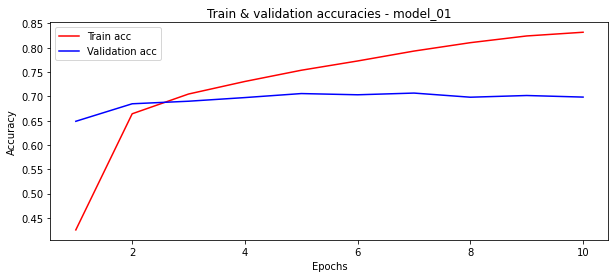

In [60]:
modelize(model1, 10, DATA, "model_01")